In [1]:
# In order to import from the python file without hassle, we add the current
# directory to the python path
import sys; sys.path.append(".")

# Auto-reload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import pickle
import torch.nn as nn
import torchvision
import torch
import torchvision.transforms as transforms
import torch.optim as optim
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def save_model(name: str, obj) -> None:
    with open(f"data/{name}.pckl", "wb") as f:
        pickle.dump(obj, f)


def load_model(name: str):
    with open(f"data/{name}.pckl", "rb") as f:
        return pickle.load(f)

# Loading the data

We will use a bird dataset, where the task is to classify each image into one of 400 different classes of birds.

## Data Loader

* PyTorch typically uses Dataset and DataLoader classes to load data during training. The DataLoader enables processing data on multiple cores (num_workers argument), which is useful as the data loading speed is commonly the bottleneck in network training.

* The batch size used during training is also usually an argument of the DataLoader. 

* We will be using the torchvision.datasets.ImageFolder class that can easily load images that have been separated into individual folders by class. The data loader then outputs the data in the form of (image, label) pairs. For tasks other than classification, custom dataset classes are more common.

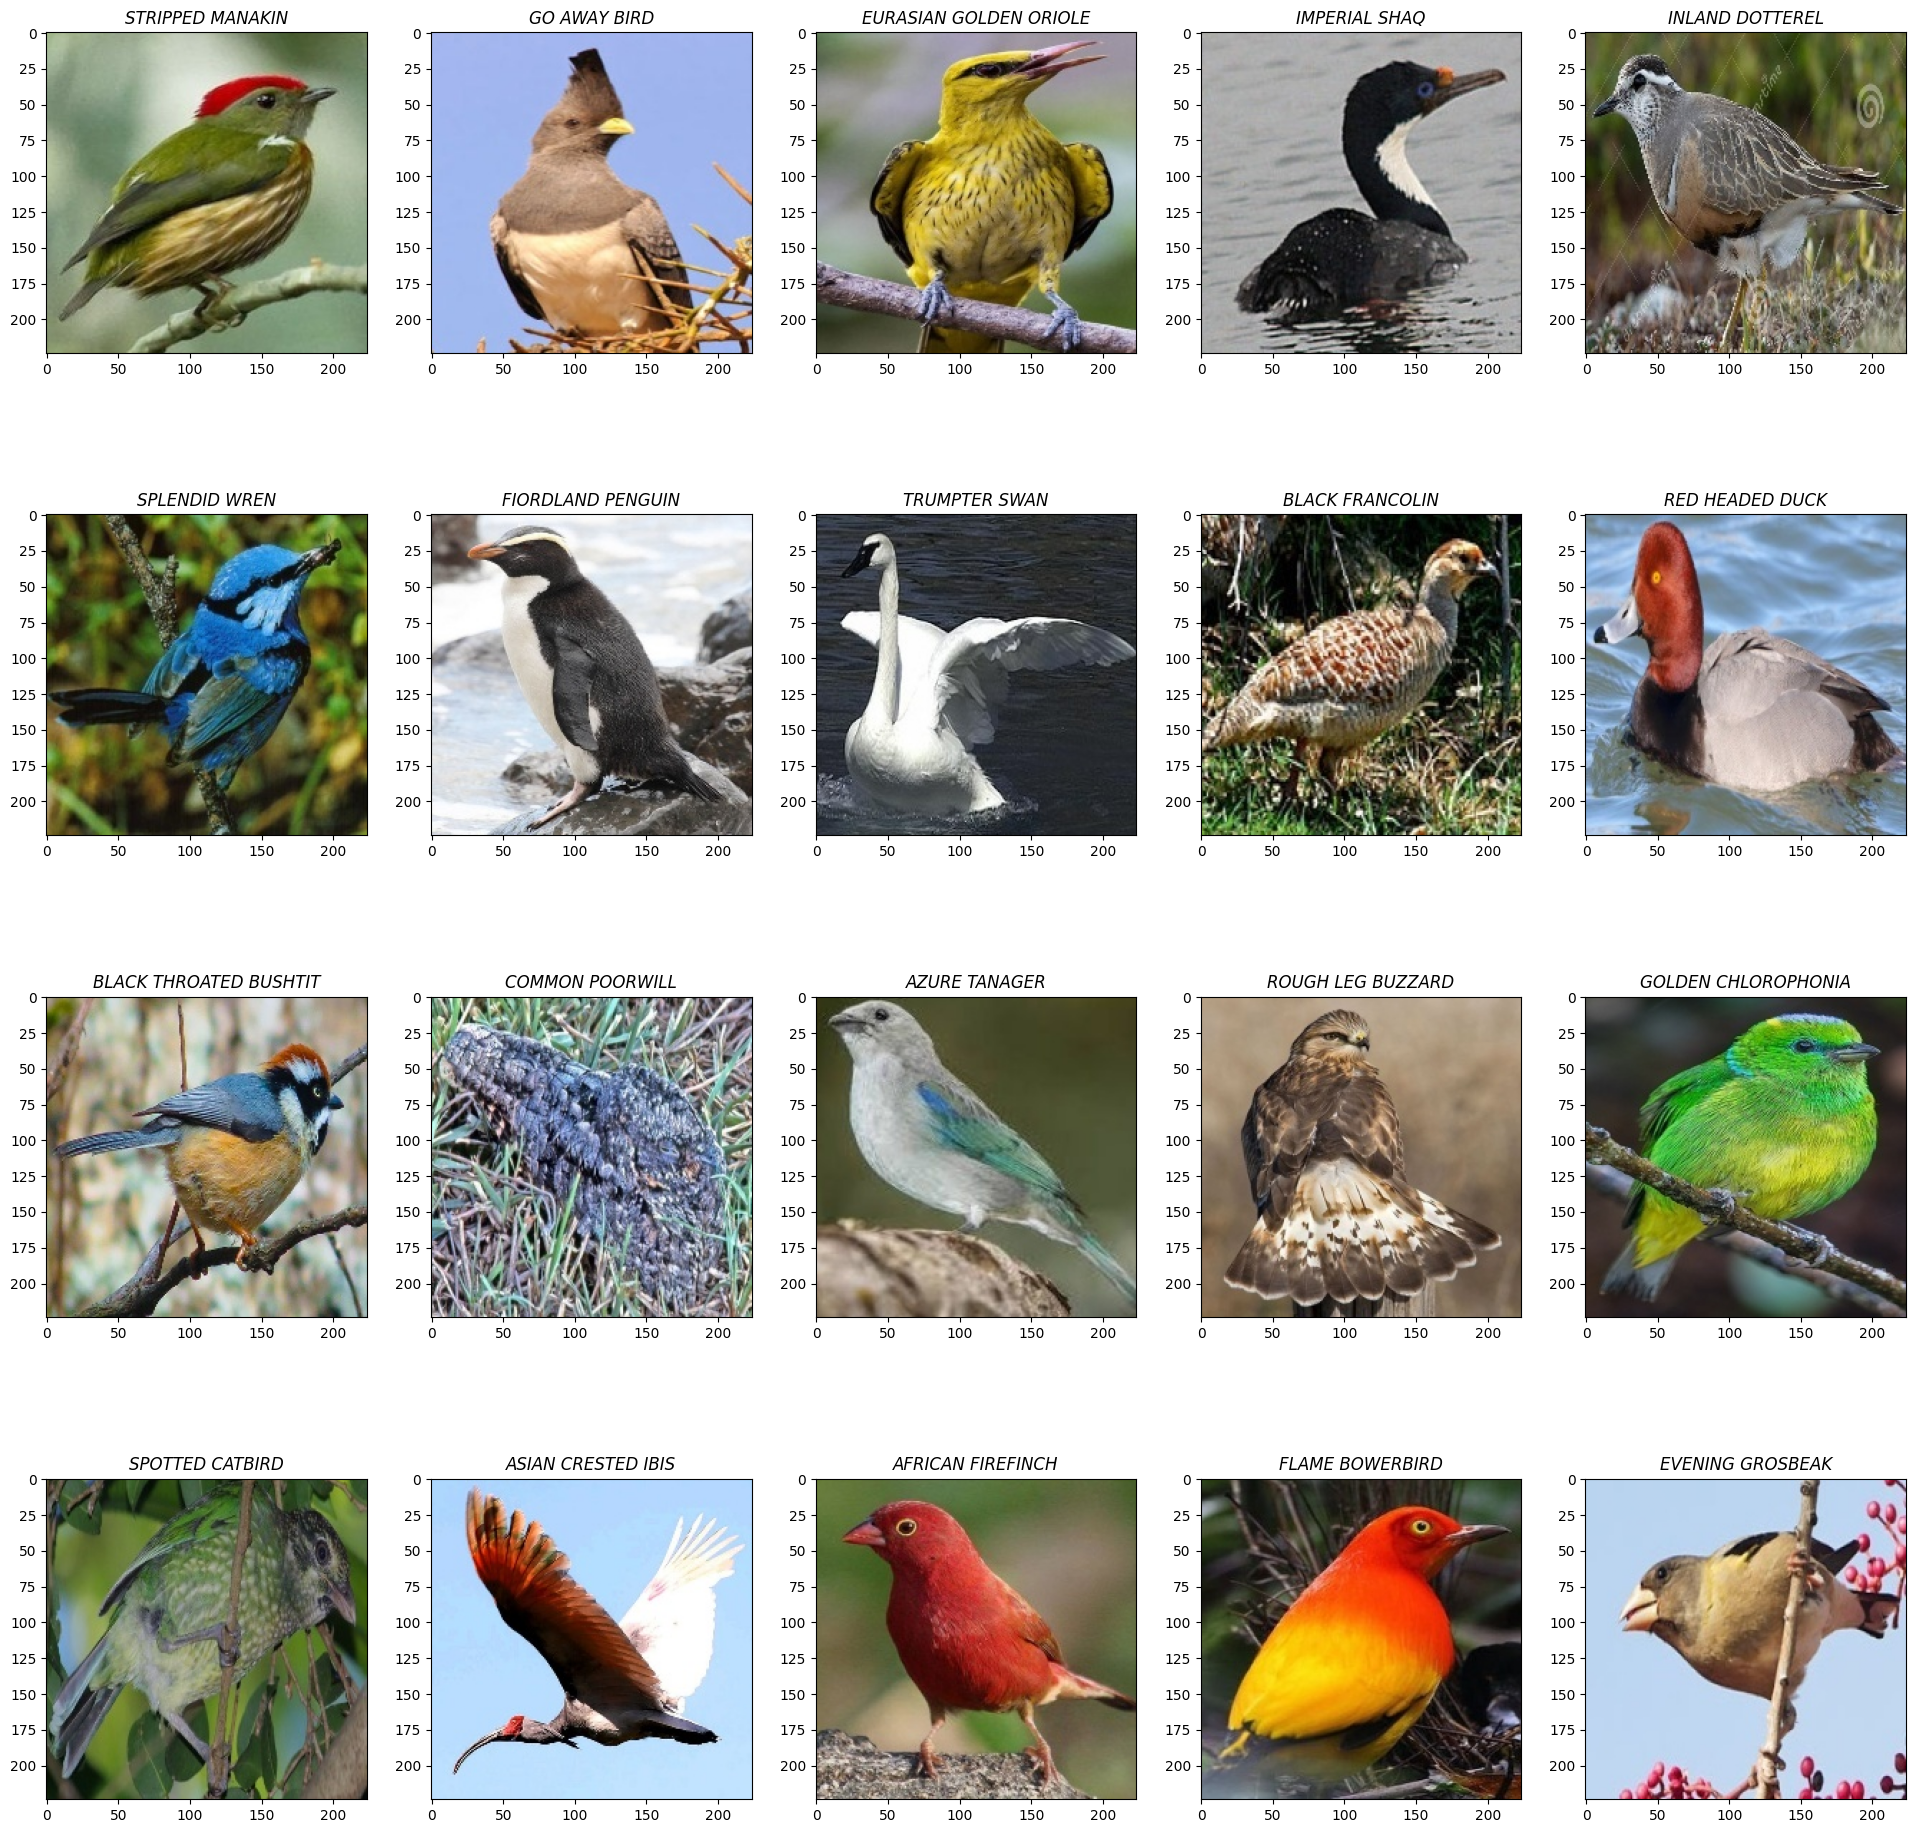

In [4]:
batch_size = 32
# Transforms can also be used for image augmentation - https://pytorch.org/vision/stable/transforms.html
transform = transforms.Compose(
    [
    transforms.ToTensor()
    ])

transform_test = transforms.Compose(
    [transforms.ToTensor()
    ])


trainset = torchvision.datasets.ImageFolder(root='./data/bird_data/train/',transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.ImageFolder(root='./data/bird_data/test/', transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

valset = torchvision.datasets.ImageFolder(root='./data/bird_data/valid/',transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)


# Displaying random trainset images
import matplotlib.pyplot as plt
import numpy as np
fig=plt.figure(figsize=(24, 24))
columns = 5
rows = 4
for i in range(columns*rows):
  input, label = trainset[np.random.randint(len(trainset))]
  img = input.detach().numpy().transpose((1,2,0))
  ax = fig.add_subplot(rows, columns, i+1)
  ax.set_title(trainset.classes[label], fontstyle='italic')
  plt.imshow(img)
plt.show()



# ResNet18 implementation

ResNet paper:
https://arxiv.org/pdf/1512.03385.pdf

The implementation details of ResNet18 are listed in Table 1 of the paper.



In [5]:
class InputLayer(nn.Module):
    def __init__(self, inputs, outputs):
        super(InputLayer, self).__init__()
        self.relu = nn.ReLU()
        self.conv = nn.Conv2d(inputs, outputs, 7, stride=2, padding=3)
        self.bn = nn.BatchNorm2d(outputs)
        self.maxpool = nn.MaxPool2d(inputs, stride=2, padding=1)

    def forward(self, x):
        return self.maxpool(self.relu(self.bn(self.conv(x))))


class HiddenLayer(nn.Module):
    def __init__(self, inputs, outputs, stride=1):
        super(HiddenLayer, self).__init__()
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm2d(outputs)
        self.conv_1 = nn.Conv2d(inputs, outputs, 3, stride=stride, padding=1)
        self.conv_2 = nn.Conv2d(outputs, outputs, 3, stride=1, padding=1)

    def forward(self, x):
        rep_1 = self.relu(self.bn(self.conv_1(x)))
        rep_2 = self.relu(self.bn(self.conv_2(rep_1)))
        rep_3 = self.relu(self.bn(self.conv_2(rep_2)))
        return self.bn(self.conv_2(rep_3))


class OutputLayer(nn.Module):
    def __init__(self, inputs, outputs):
        super(OutputLayer, self).__init__()
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(inputs, outputs)

    def forward(self, x):
        a = self.avgpool(x)
        return self.fc(a.reshape(a.shape[0], -1))


class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()

        self.relu = nn.ReLU()
        self.initial_layer = InputLayer(3, 64)
        self.layer_0 = HiddenLayer(64, 64)
        self.layer_1 = HiddenLayer(64, 128, 2)
        self.layer_2 = HiddenLayer(128, 256, 2)
        self.layer_3 = HiddenLayer(256, 512, 2)
        self.output_layer = OutputLayer(512, 400)

    def forward(self, x):
        i = self.initial_layer(x)
        l0 = self.layer_0(i)
        l1 = self.layer_1(l0)
        l2 = self.layer_2(l1)
        l3 = self.layer_3(l2)
        return self.output_layer(l3)

In [6]:
def test_resnet_model(net, curr_data_loader, val_test="val"):
    # Testing

    criterion = nn.CrossEntropyLoss()

    num_images = len(curr_data_loader.dataset)
    gt_array = np.zeros(num_images)
    pred_array = np.zeros(num_images)

    correct = 0
    total = 0
    running_loss = 0.0
    net.eval()
    with torch.no_grad():
        for i,data in enumerate(curr_data_loader):
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            gt_array[i*labels.size(0):(i+1)*labels.size(0)] = labels.detach().cpu().numpy()
            pred_array[i*labels.size(0):(i+1)*labels.size(0)] = predicted.detach().cpu().numpy()

    print('Accuracy of the network on %s images: %d %%' % (val_test,
            100 * correct / total))
    print("Test loss: "+str(running_loss/(total/4)))
    return gt_array, pred_array

def train_resnet_model(epochs, lr):
    net = ResNet()
    net.cuda()

    # Define the loss function
    criterion = nn.CrossEntropyLoss()

    # Initialize the optimizer
    optimizer = optim.Adam(net.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    
    for epoch in range(epochs):
        with tqdm(total=len(trainset), desc ='Epoch: '+str(epoch)+"/"+str(epochs), unit='img') as prog_bar:
            for i, data in enumerate(trainloader, 0):
                # Get the inputs; Data is a tuple of (images, labels)
                inputs, labels = data
                # Transfer the images and labels to the GPU.
                inputs = inputs.cuda()
                labels = labels.cuda()

                # Clear the saved gradients of the previous iteration
                optimizer.zero_grad()

                outputs = net(inputs)
                # Calculate the loss value
                loss = criterion(outputs, labels)
                # Calculate the gradients using backpropagation
                loss.backward()
                # Update the weights of the network using the chosen optimizer
                optimizer.step()

                prog_bar.set_postfix(**{'loss': loss.data.cpu().detach().numpy()})
                prog_bar.update(batch_size)
            scheduler.step()
        
        
        test_resnet_model(net, valloader)
    test_resnet_model(net,testloader)

    return net
        



In [21]:
net = train_resnet_model(15,0.0001)

Epoch: 0/15: 58400img [02:22, 408.83img/s, loss=3.0020719]                          


Accuracy of the network on val images: 3 %
Test loss: 0.6715045299530029


Epoch: 1/15: 58400img [02:25, 401.65img/s, loss=2.9412694]                          


Accuracy of the network on val images: 54 %
Test loss: 0.2261462869644165


Epoch: 2/15: 58400img [02:16, 428.67img/s, loss=1.8883972]                           


Accuracy of the network on val images: 66 %
Test loss: 0.16065081524848937


Epoch: 3/15: 58400img [02:19, 419.74img/s, loss=2.1521375]                           


Accuracy of the network on val images: 75 %
Test loss: 0.12439241433143616


Epoch: 4/15: 58400img [02:18, 420.92img/s, loss=1.0043576]                           


Accuracy of the network on val images: 79 %
Test loss: 0.1027806710600853


Epoch: 5/15: 58400img [02:20, 415.28img/s, loss=1.5178151]                           


Accuracy of the network on val images: 80 %
Test loss: 0.09364631319046021


Epoch: 6/15: 58400img [02:20, 416.13img/s, loss=1.1445742]                           


Accuracy of the network on val images: 81 %
Test loss: 0.08854443141818047


Epoch: 7/15: 58400img [02:18, 422.57img/s, loss=0.26852527]                           


Accuracy of the network on val images: 82 %
Test loss: 0.08659760975837708


Epoch: 8/15: 58400img [02:18, 421.12img/s, loss=0.27778688]                          


Accuracy of the network on val images: 82 %
Test loss: 0.08939341789484025


Epoch: 9/15: 58400img [02:22, 410.24img/s, loss=0.4628994]                            


Accuracy of the network on val images: 83 %
Test loss: 0.09314054664969444


Epoch: 10/15: 58400img [02:23, 406.12img/s, loss=0.009565721]                            


Accuracy of the network on val images: 88 %
Test loss: 0.06982594824954867


Epoch: 11/15: 58400img [02:20, 415.97img/s, loss=0.002972414]                             


Accuracy of the network on val images: 89 %
Test loss: 0.08476753090444254


Epoch: 12/15: 58400img [02:19, 420.04img/s, loss=0.067273475]                             


Accuracy of the network on val images: 89 %
Test loss: 0.0958141109785065


Epoch: 13/15: 58400img [02:18, 422.89img/s, loss=0.008458689]                             


Accuracy of the network on val images: 89 %
Test loss: 0.11431384045630694


Epoch: 14/15: 58400img [02:17, 423.90img/s, loss=0.0048845145]                            


Accuracy of the network on val images: 89 %
Test loss: 0.12227040973881959
Accuracy of the network on val images: 92 %
Test loss: 0.07034047079650918


In [22]:
save_model("resnet_92_percent", net)

Accuracy of the network on val images: 92 %
Test loss: 0.07034047079650918


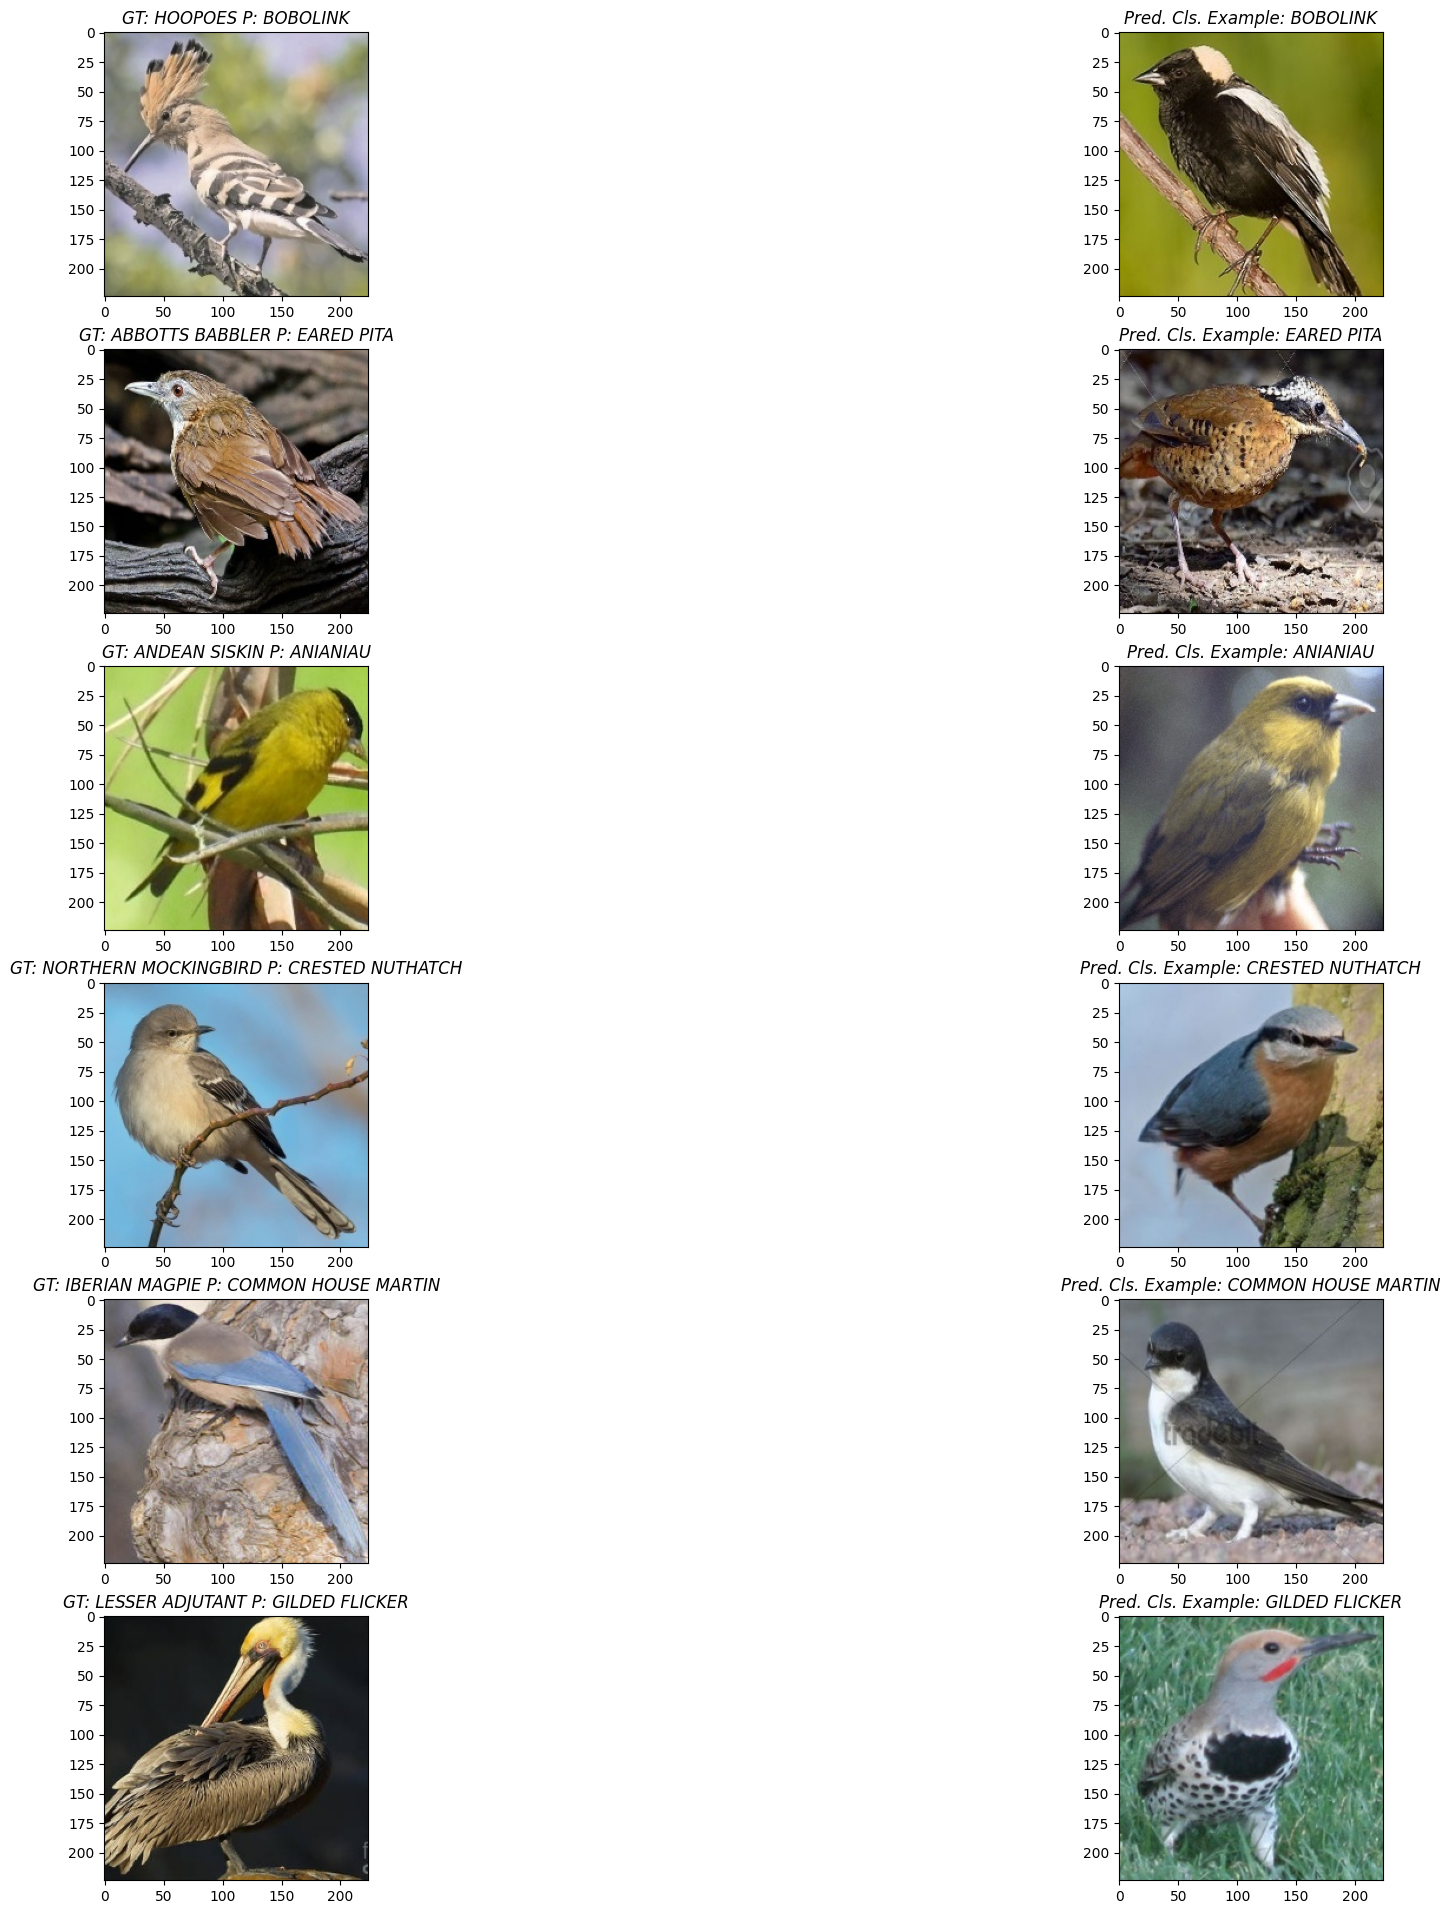

In [23]:
gt_array, pred_array = test_resnet_model(net, testloader)

# Displaying random misclassified images
fig = plt.figure(figsize=(24, 24))
columns = 2
rows = 6
mistake_indices = np.nonzero(gt_array != pred_array)[0]
for i in range(rows):
    chosen_index = mistake_indices[np.random.randint(len(mistake_indices))]
    input, label = testset[chosen_index]
    pred_label = pred_array[chosen_index].astype(np.int32)
    pred_cls_samples = np.nonzero(gt_array == pred_label)[0]
    pred_cls_input, _ = testset[
        pred_cls_samples[np.random.randint(len(pred_cls_samples))]
    ]

    img = input.detach().numpy().transpose((1, 2, 0))
    ax = fig.add_subplot(rows, columns, columns * i + 1)
    im_title = "GT: " + trainset.classes[label] + " P: " + trainset.classes[pred_label]
    ax.set_title(im_title, fontstyle="italic")
    plt.imshow(img)

    img_sample = pred_cls_input.detach().numpy().transpose((1, 2, 0))
    ax = fig.add_subplot(rows, columns, columns * i + 2)
    im_title = "Pred. Cls. Example: " + trainset.classes[pred_label]
    ax.set_title(im_title, fontstyle="italic")
    plt.imshow(img_sample)

plt.show()